In [2]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt
import json

In [3]:
EXPERIMENT_NAME = 'P3856'
EXPERIMENT_DIR = '/data2/experiments/{}'.format(EXPERIMENT_NAME)

In [4]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

#### select the sequence/charge of interest, and the runs to look at

In [5]:
selected_sequence = 'FQHQSSFTEQSIK'
selected_sequence_charge = 2

In [6]:
EXTRACTED_FEATURES_DB_NAME = '{}/extracted-features/extracted-features.sqlite'.format(EXPERIMENT_DIR)
print('loading the extractions from {}'.format(EXTRACTED_FEATURES_DB_NAME))
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
selected_sequence_df = pd.read_sql_query("select * from features where sequence==\'{}\' and charge=={}".format(selected_sequence, selected_sequence_charge), db_conn)
db_conn.close()

loading the extractions from /data2/experiments/P3856/extracted-features/extracted-features.sqlite


In [7]:
selected_sequence_df['short_run_name'] = selected_sequence_df.apply(lambda row: '_'.join(row.run_name.split('_Slot')[0].split('_')[1:3]), axis=1)

In [8]:
selected_sequence_df['isotope_intensities_l'] = selected_sequence_df.apply(lambda row: json.loads(row.isotope_intensities_l), axis=1)

In [9]:
selected_sequence_df['short_run_name'] = selected_sequence_df.apply(lambda row: '_'.join(row.run_name.split('_Slot')[0].split('_')[1:3]), axis=1)

In [10]:
selected_sequence_df

,sequence,charge,file_idx,peak_idx,target_coords,theoretical_mz,q_value,delta_mz_ppm,delta_rt,delta_scan,...,monoisotopic_mz_delta_ppm,number_of_isotopes,peak_proportion_intensity,peak_proportions,rt_apex,scan_apex,run_name,group,human,short_run_name
0,FQHQSSFTEQSIK,2,8,1,"{""mono_mz"": 783.8818504135556, ""scan_apex"": 53...",783.880976,0.008905,1.672479,-0.010240,0.008325,...,1.672479,7,19919,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1776.678941,544,P3856_YHE211_6_Slot1-1_1_5109,P3856,0,YHE211_6
1,FQHQSSFTEQSIK,2,10,0,"{""mono_mz"": 783.8815755711909, ""scan_apex"": 53...",783.880976,0.008905,-0.506860,-0.000877,-0.024741,...,-0.506860,7,13661,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1794.659095,519,P3856_YHE211_10_Slot1-1_1_5113,P3856,0,YHE211_10
2,FQHQSSFTEQSIK,2,19,0,"{""mono_mz"": 783.8815278298548, ""scan_apex"": 53...",783.880976,0.008905,1.694980,0.002036,-0.004519,...,1.694980,7,17549,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1800.081067,530,P3856_YHE010_9_Slot1-1_1_5101,P3856,0,YHE010_9
3,FQHQSSFTEQSIK,2,18,0,"{""mono_mz"": 783.8821936972383, ""scan_apex"": 52...",783.880976,0.008905,1.212376,0.001362,-0.008789,...,1.212376,7,10213,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1797.620194,524,P3856_YHE211_8_Slot1-1_1_5111,P3856,0,YHE211_8
4,FQHQSSFTEQSIK,2,4,2,"{""mono_mz"": 783.8806529350101, ""scan_apex"": 53...",783.880976,0.008905,-3.059979,-0.016775,-0.029577,...,-3.059979,7,17107,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1764.485177,518,P3856_YHE114_2_Slot1-1_1_5116,P3856,0,YHE114_2
5,FQHQSSFTEQSIK,2,27,0,"{""mono_mz"": 783.8804926445717, ""scan_apex"": 52...",783.880976,0.008905,-2.992461,0.003792,-0.032974,...,-2.992461,7,18435,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1807.854635,510,P3856_YHE114_10_Slot1-1_1_5124,P3856,0,YHE114_10
6,FQHQSSFTEQSIK,2,22,1,"{""mono_mz"": 783.8809242913957, ""scan_apex"": 53...",783.880976,0.008905,0.173721,0.013385,-0.000233,...,0.173721,7,9124,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1803.535137,537,P3856_YHE010_1_Slot1-1_1_5093,P3856,0,YHE010_1
7,FQHQSSFTEQSIK,2,16,2,"{""mono_mz"": 783.8813851193669, ""scan_apex"": 52...",783.880976,0.008905,-0.088133,0.012215,0.056781,...,-0.088133,7,24096,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1817.431415,558,P3856_YHE114_6_Slot1-1_1_5120,P3856,0,YHE114_6
8,FQHQSSFTEQSIK,2,13,0,"{""mono_mz"": 783.8812684014168, ""scan_apex"": 53...",783.880976,0.008905,-0.119522,0.003336,-0.013636,...,-0.119522,7,5965,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1800.920436,529,P3856_YHE010_10_Slot1-1_1_5102,P3856,0,YHE010_10
9,FQHQSSFTEQSIK,2,23,0,"{""mono_mz"": 783.8812155266814, ""scan_apex"": 53...",783.880976,0.008905,-0.373868,0.002821,0.003400,...,-0.373868,7,10515,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1800.174851,537,P3856_YHE010_8_Slot1-1_1_5100,P3856,0,YHE010_8


In [11]:
# the runs of interest for comparison
run_name_A = 'YHE114_7'
run_name_B = 'YHE114_6'

In [12]:
full_run_name_A = selected_sequence_df[selected_sequence_df.short_run_name == run_name_A].iloc[0].run_name
full_run_name_B = selected_sequence_df[selected_sequence_df.short_run_name == run_name_B].iloc[0].run_name

In [13]:
file_idx_A = file_idx_for_run(full_run_name_A)
file_idx_B = file_idx_for_run(full_run_name_B)

In [14]:
file_idx_A, file_idx_B

(12, 16)

#### compare the sequence in run A

In [15]:
# get the row for the selected run
sequence_in_file_A = selected_sequence_df[selected_sequence_df.short_run_name == run_name_A].iloc[0]

# convert the list of isotopes for thie sequence in this run into a DF
isotopes_A_df = pd.DataFrame(sequence_in_file_A.isotope_intensities_l, columns=['summed_intensity','saturated','inferred_intensity','inferred','isotope_points','isotope_apex_points'])

# extract the raw points of each isotope
frame_ids_A = set()
isotope_points_A_l = []
isotope_apex_points_A_l = []

for idx,isotope in isotopes_A_df.iterrows():
    points_l = isotope.isotope_points
    isotope_points_df = pd.DataFrame(points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_points_A_l.append(isotope_points_df)
    
    apex_points_l = isotope.isotope_apex_points
    isotope_apex_points_df = pd.DataFrame(apex_points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_apex_points_A_l.append(isotope_apex_points_df)
    frame_ids_A = frame_ids_A.union(isotope_apex_points_df.frame_id.astype(int).to_list())

# the frames to extract for the sequence's apex in RT
print("extract these frames from {}: {}".format(run_name_A, ' '.join([str(v) for v in frame_ids_A])))

extract these frames from YHE114_7: 17112 17107 17117


#### compare the sequence in run B

In [16]:
# get the row for the selected run
sequence_in_file_B = selected_sequence_df[selected_sequence_df.short_run_name == run_name_B].iloc[0]

# convert the list of isotopes for thie sequence in this run into a DF
isotopes_B_df = pd.DataFrame(sequence_in_file_B.isotope_intensities_l, columns=['summed_intensity','saturated','inferred_intensity','inferred','isotope_points','isotope_apex_points'])

# extract the raw points of each isotope
frame_ids_B = set()
isotope_points_B_l = []
isotope_apex_points_B_l = []

for idx,isotope in isotopes_B_df.iterrows():
    points_l = isotope.isotope_points
    isotope_points_df = pd.DataFrame(points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_points_B_l.append(isotope_points_df)
    
    apex_points_l = isotope.isotope_apex_points
    isotope_apex_points_df = pd.DataFrame(apex_points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_apex_points_B_l.append(isotope_apex_points_df)
    frame_ids_B = frame_ids_B.union(isotope_apex_points_df.frame_id.astype(int).to_list())

# the frames to extract for the sequence's apex in RT
print("extract these frames from {}: {}".format(run_name_B, ' '.join([str(v) for v in frame_ids_B])))

extract these frames from YHE114_6: 16274 16284 16279


In [17]:
CONVERTED_DATABASE_NAME_A = '{}/converted-databases/exp-{}-run-{}-converted.sqlite'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, full_run_name_A)
CONVERTED_DATABASE_NAME_B = '{}/converted-databases/exp-{}-run-{}-converted.sqlite'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, full_run_name_B)

In [18]:
isotope_points_A_df = pd.concat(isotope_points_A_l)

rt_lower = isotope_points_A_l[0].retention_time_secs.min()
rt_upper = isotope_points_A_l[0].retention_time_secs.max()
scan_lower = isotope_points_A_l[0].scan.min()
scan_upper = isotope_points_A_l[0].scan.max()
mz_lower = isotope_points_A_df.mz.min()
mz_upper = isotope_points_A_df.mz.max()


# rt_lower = sequence_in_file_A.rt_apex - (0.5 * sequence_in_file_A.peak_base_width_rt_0)
# rt_upper = sequence_in_file_A.rt_apex + (0.5 * sequence_in_file_A.peak_base_width_rt_0)
# scan_lower = sequence_in_file_A.scan_apex - (5 * sequence_in_file_A.peak_base_width_scan_0)
# scan_upper = sequence_in_file_A.scan_apex + (5 * sequence_in_file_A.peak_base_width_scan_0)
# mz_lower = sequence_in_file_A.monoisotopic_mz_centroid - 1
# mz_upper = sequence_in_file_A.monoisotopic_mz_centroid + 7

db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME_A)
frames_subset_A_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type==0 and retention_time_secs > {} and retention_time_secs < {} and scan > {} and scan < {} and mz > {} and mz < {}".format(rt_lower, rt_upper, scan_lower, scan_upper, mz_lower, mz_upper), db_conn)
db_conn.close()

In [19]:
isotope_points_B_df = pd.concat(isotope_points_B_l)

rt_lower = isotope_points_B_l[0].retention_time_secs.min()
rt_upper = isotope_points_B_l[0].retention_time_secs.max()
scan_lower = isotope_points_B_l[0].scan.min()
scan_upper = isotope_points_B_l[0].scan.max()
mz_lower = isotope_points_B_df.mz.min()
mz_upper = isotope_points_B_df.mz.max()

db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME_B)
frames_subset_B_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type==0 and retention_time_secs > {} and retention_time_secs < {} and scan > {} and scan < {} and mz > {} and mz < {}".format(rt_lower, rt_upper, scan_lower, scan_upper, mz_lower, mz_upper), db_conn)
db_conn.close()

In [20]:
frame_subset_intensity_max = max(frames_subset_A_df.intensity.max(), frames_subset_B_df.intensity.max())
frame_subset_intensity_max

4745

#### recall the estimated coordinates for the selected sequence

In [21]:
estimated_coords_A_df = pd.read_pickle('{}/target-decoy-models/library-sequences-in-run-{}.pkl'.format(EXPERIMENT_DIR, full_run_name_A))
estimated_coords_A = estimated_coords_A_df[(estimated_coords_A_df.sequence == selected_sequence) & (estimated_coords_A_df.charge == selected_sequence_charge)].iloc[0].target_coords

In [23]:
estimated_coords_B_df = pd.read_pickle('{}/target-decoy-models/library-sequences-in-run-{}.pkl'.format(EXPERIMENT_DIR, full_run_name_B))
estimated_coords_B = estimated_coords_B_df[(estimated_coords_B_df.sequence == selected_sequence) & (estimated_coords_B_df.charge == selected_sequence_charge)].iloc[0].target_coords

In [24]:
estimated_coords_A

{'mono_mz': 783.881063010965,
 'scan_apex': 532.9783001907429,
 'rt_apex': 1796.241602231046}

#### plots for comparing the selected sequence in run A and run B

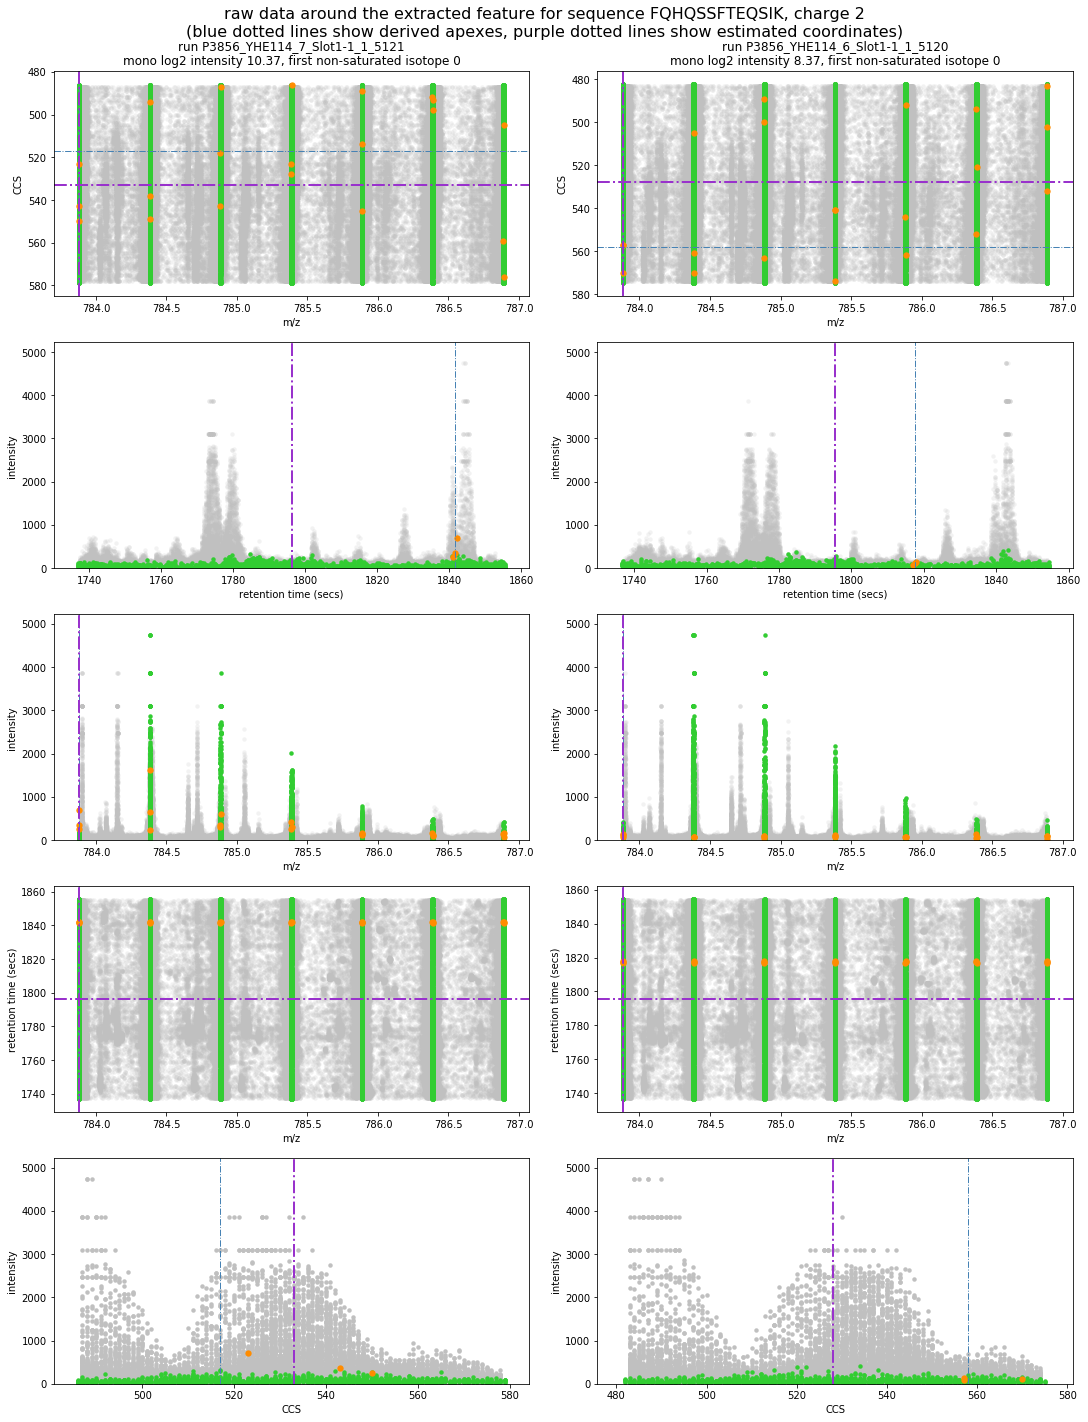

In [27]:
f, axarr = plt.subplots(nrows=5, ncols=2, constrained_layout=True)

f.set_figheight(20)
f.set_figwidth(15)
plt.margins(0.06)
f.suptitle('raw data around the extracted feature for sequence {}, charge {}\n(blue dotted lines show derived apexes, purple dotted lines show estimated coordinates)\n'.format(selected_sequence, selected_sequence_charge), fontsize=16)

########
# run A - mz vs scan
########
ax = axarr[0,0]  # row, column
ax.set_title('run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(sequence_in_file_A.run_name, round(np.log2(sequence_in_file_A.intensity),2), sequence_in_file_A.isotope_idx_not_in_saturation))

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_A_l:
    ax.scatter(df.mz, df.scan, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_A_l:
    ax.scatter(df.mz, df.scan, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_A.monoisotopic_mz_centroid, color='steelblue', lw=1.0, ls='-.')
ax.axhline(sequence_in_file_A.scan_apex, color='steelblue', lw=1.0, ls='-.')

# draw the estimated monoisotopic apex
ax.axvline(estimated_coords_A['mono_mz'], color='darkorchid', lw=2.0, ls='-.')
ax.axhline(estimated_coords_A['scan_apex'], color='darkorchid', lw=2.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run A - RT vs intensity
########
ax = axarr[1,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.retention_time_secs, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
df = isotope_points_A_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_A_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_A.rt_apex, color='steelblue', lw=1.0, ls='-.')

# draw the estimated apex
ax.axvline(estimated_coords_A['rt_apex'], color='darkorchid', lw=2.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run A - mz vs intensity
########
ax = axarr[2,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_A_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_A_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_A.monoisotopic_mz_centroid, color='steelblue', lw=1.0, ls='-.')

# draw the estimated apex
ax.axvline(estimated_coords_A['mono_mz'], color='darkorchid', lw=2.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('m/z')
ax.set_ylabel('intensity')

########
# run A - mz vs RT
########
ax = axarr[3,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.retention_time_secs, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_A_l:
    ax.scatter(df.mz, df.retention_time_secs, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_A_l:
    ax.scatter(df.mz, df.retention_time_secs, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_A.monoisotopic_mz_centroid, color='steelblue', lw=1.0, ls='-.')

# draw the estimated apex
ax.axvline(estimated_coords_A['mono_mz'], color='darkorchid', lw=2.0, ls='-.')
ax.axhline(estimated_coords_A['rt_apex'], color='darkorchid', lw=2.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('retention time (secs)')

########
# run A - CCS vs intensity
########
ax = axarr[4,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.scan, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=1.0)

# plot the isotope points
df = isotope_points_A_l[0]
ax.scatter(df.scan, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_A_l[0]
ax.scatter(df.scan, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_A.scan_apex, color='steelblue', lw=1.0, ls='-.')

# draw the estimated apex
ax.axvline(estimated_coords_A['scan_apex'], color='darkorchid', lw=2.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('CCS')
ax.set_ylabel('intensity')





########
# run B - mz vs scan
########
ax = axarr[0,1]
ax.set_title('run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(sequence_in_file_B.run_name, round(np.log2(sequence_in_file_B.intensity),2), sequence_in_file_B.isotope_idx_not_in_saturation))

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_B_l:
    ax.scatter(df.mz, df.scan, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_B_l:
    ax.scatter(df.mz, df.scan, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_B.monoisotopic_mz_centroid, color='steelblue', lw=1.0, ls='-.')
ax.axhline(sequence_in_file_B.scan_apex, color='steelblue', lw=1.0, ls='-.')

# draw the estimated apex
ax.axvline(estimated_coords_B['mono_mz'], color='darkorchid', lw=2.0, ls='-.')
ax.axhline(estimated_coords_B['scan_apex'], color='darkorchid', lw=2.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run B - RT vs intensity
########
ax = axarr[1,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.retention_time_secs, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
df = isotope_points_B_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_B_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_B.rt_apex, color='steelblue', lw=1.0, ls='-.')

# draw the estimated apex
ax.axvline(estimated_coords_B['rt_apex'], color='darkorchid', lw=2.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run B - mz vs intensity
########
ax = axarr[2,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_B_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_B_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_B.monoisotopic_mz_centroid, color='steelblue', lw=1.0, ls='-.')

# draw the estimated apex
ax.axvline(estimated_coords_B['mono_mz'], color='darkorchid', lw=2.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('m/z')
ax.set_ylabel('intensity')

########
# run B - mz vs RT
########
ax = axarr[3,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.retention_time_secs, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_B_l:
    ax.scatter(df.mz, df.retention_time_secs, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_B_l:
    ax.scatter(df.mz, df.retention_time_secs, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_B.monoisotopic_mz_centroid, color='steelblue', lw=1.0, ls='-.')

# draw the estimated apex
ax.axvline(estimated_coords_B['mono_mz'], color='darkorchid', lw=2.0, ls='-.')
ax.axhline(estimated_coords_B['rt_apex'], color='darkorchid', lw=2.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('retention time (secs)')

########
# run B - CCS vs intensity
########
ax = axarr[4,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.scan, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=1.0)

# plot the isotope points
df = isotope_points_B_l[0]
ax.scatter(df.scan, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_B_l[0]
ax.scatter(df.scan, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the derived apex
ax.axvline(sequence_in_file_B.scan_apex, color='steelblue', lw=1.0, ls='-.')

# draw the estimated apex
ax.axvline(estimated_coords_B['scan_apex'], color='darkorchid', lw=2.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('CCS')
ax.set_ylabel('intensity')


plt.show()